# ME4 Machine Learning - Tutorial 3

For simplicity, X-rays are often considered to have linear attenuation behaviour, which means that if the X-ray travels through a material a distance d, it will lose a particular fraction of its power, and if it travels through another distance d then it will lose the same fraction. This results in an exponential decay as the X-ray propagates. This is very convenient in many applications, particularly X-ray CT image generation, which relies on exactly this assumption. 

In practice, there is a phenomenon called ‘beam hardening’ which means that as an X-ray passes through an object, the beam becomes ‘harder’, i.e. more difficult to attenuate, so the attenuation value reduces. This means the behaviour will no longer be linear. We can try to address the challenges by finding a simple polynomial relationship, which is where regression becomes valuable.

**coursework tasks.*

In [12]:
import sys
# setting path
sys.path.append('..')

from helperlib import (
    mathfunctions as hmath, 
    arrayfunctions as harray) 

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

np.random.seed(5)

# Don't show plots inline
%matplotlib agg

## 1. Standard linear regression

### 1.1. Import dataset

In [13]:
df = pd.read_csv('xray.csv')

x = np.array(df['Distance (mm)'][:])
y = np.array(df['Total absorption'][:])

### 1.2. Perform linear regression*

**Approximation**: 

$ f(x_i) = \beta_1 + \beta_2 x_i = y_i + E_i $

Using $l_2$ error metric: 

$ E_2 = \sqrt{\sum_{i=1}^{m}[f(x_i) - y_i] ^ 2} $

Parameters for min $E_2$:

`params_o1` = 
$ \begin{pmatrix}
\beta_1 \\ \beta_2
\end{pmatrix} = 
\begin{pmatrix}
 \sum x_i & \sum x_i ^ 2 \\
 m & \sum x_i \\
\end{pmatrix} ^ {-1} \begin{pmatrix}
\sum y_i x_i \\ \sum y_i
\end{pmatrix} $

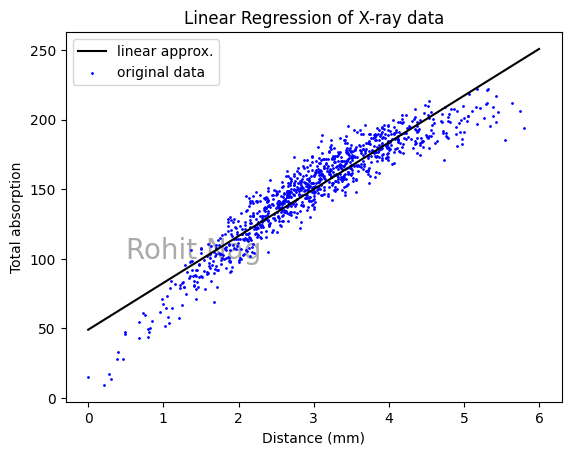

In [14]:
# Calculate parameters:
A_o1 = np.array([[sum(x), sum(x ** 2)], [len(x), sum(x)]])
b_o1 = np.array([np.dot(x, y), sum(y)]).T
params_o1 = np.matmul(np.linalg.inv(A_o1), b_o1)

# Plot regression line against original data:
x_o1_approx = np.linspace(0, 6, 200)
y_o1_approx = params_o1[0] + params_o1[1] * x_o1_approx
fig, ax = plt.subplots()
ax.set_title('Linear Regression of X-ray data')
ax.set_xlabel('Distance (mm)')
ax.set_ylabel('Total absorption')
ax.text(0.5, 100, 'Rohit Nag', size=20, zorder=0., color='#aaaaaa')
ax.plot(x_o1_approx, y_o1_approx, c='k', label='linear approx.')
ax.scatter(x, y, c='b', s=1, label='original data')
ax.legend()
fig

## 2. Higher order regression*

### 2.1. Fit a quadratic function, form $f(x) = \beta_1+ \beta_2 x + \beta_3 x ^ 2$ to the data.

Parameters for min $E_2$:

`params_o2` = 
$ \begin{pmatrix}
\beta_1 \\ \beta_2 \\ \beta_3
\end{pmatrix} = 
\begin{pmatrix}
\sum x_i ^ 2 & \sum x_i ^ 3 & \sum x_i ^ 4 \\
\sum x_i & \sum x_i ^ 2 & \sum x_i ^ 3 \\
m & \sum x_i & \sum x_i ^ 2 \\
\end{pmatrix} ^ {-1} \begin{pmatrix}
\sum x_i ^ 2 y_i \\ \sum x_i y_i \\ \sum y_i
\end{pmatrix} $

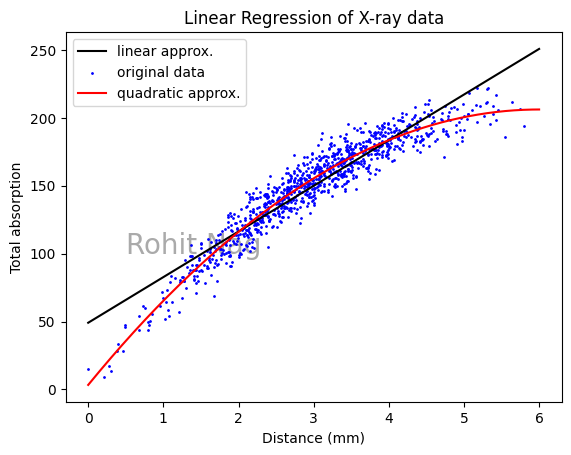

In [15]:
# Calculate parameters:
A_o2 = np.array([
    [sum(x ** 2), sum(x ** 3), sum(x ** 4)], 
    [sum(x), sum(x ** 2), sum(x ** 3)], 
    [len(x), sum(x), sum(x ** 2)]])
b_o2 = np.array([np.dot(x ** 2, y), np.dot(x, y), sum(y)]).T
params = np.matmul(np.linalg.inv(A_o2), b_o2)

# Plot regression line against original data:
x_o2_approx = np.linspace(0, 6, 200)
y_o2_approx = params[0] + params[1] * x_o2_approx + params[2] * x_o2_approx ** 2
ax.plot(x_o2_approx, y_o2_approx, c='r', label='quadratic approx.')
ax.legend()
fig

### 2.2. Questions.

#### 2.2.1. Which line (linear or quadratic) will have the lower bias and why?



Quadratic line has a lower bias. This is because the higher complexity enable a lower overall discrepancy between the sample data points and the fited line.

#### 2.2.2. Which line will have the lower variance and why?

The linear fit has a lower variance as its a less complex model and is fitted the original data less. It is likely to fit to other datasets better.

#### 2.2.3. What methodology would you use to decide which of the two curves was best? And what is this methodology assessing?

I would use K-fold cross-validation. This would assess the performance of the model on various combinations of subdivisions of the original data. Ultimatelly, I'd choose the model which has the lowest average combined bias and variance. 

## 3. Using Scikit-learn to perform regression

Most ultrasonic inspection in industry is undertaken in steel components, simply because steel is such a common material. Ultrasound inspection of plastic (specifically HDPE) is significantly more complicated than steel, for a couple of reasons: attenuation is much higher and the velocity varies significantly. Steel has low attenuation because the material is quite elastic and therefore very little energy is lost from the wave. In plastic, the material is not particularly elastic and therefore waves are attenuated faster. Think about if you squeeze a plastic block, it is less likely to spring back afterwards; this causes waves to lose energy.

The velocity behaviour is also more complicated, in particular being a strong function of temperature. This is because plastic is typically much closer to its melting point than steel is, so the property change for a small increase in temperature is more significant. There may be a temperature gradient through the pipe wall thickness, and this will cause a velocity gradient, which will cause ultrasound beams to deviate and hence indicate defects at incorrect locations. We therefore need to properly understand this behaviour.

### 3.1 Read and format data

In [16]:
# read in the CSV file
df = pd.read_csv('hdpeVel.csv')

# set the 'index' column as the one containing the temperature values
df = df.set_index('T/C f/MHz')

# extract the temperature values
temp = df.index.values.astype(float)

# extract the frequency values (and scale since they are MHz)
freq = df.columns.values.astype(float) * 1e6

# extract the main part - the velocity values
vel = df.to_numpy()

# calculate the total number of values
tot_values = len(freq) * len(temp)

Create `Xgrid`, an array with every temperature, frequency pair. 

Create `ygrid`, an array with the ith velocity value corresponding to the ith temp-freq pair.

In [17]:
x1grid, x2grid = np.meshgrid(freq, temp) 
Xgrid = np.concatenate([
    x1grid.reshape([tot_values, 1]), 
	x2grid.reshape([tot_values, 1])], axis=1)
ygrid = vel.reshape([tot_values, 1])

### 3.2. Fit a linear regression line

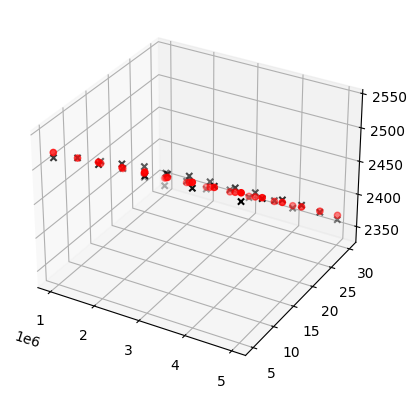

In [24]:
reg = LinearRegression()
reg.fit(Xgrid, ygrid)
y_lin = reg.predict(Xgrid)

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d') 
ax.scatter(Xgrid[:, 0], Xgrid[:, 1], ygrid, marker='x', color='#000000') 
ax.scatter(Xgrid[:, 0], Xgrid[:, 1], y_lin, marker='o', color='#ff0000')
fig

### 3.3. Fit a polynomial regression line

line in the form of 
$$ f(\bold{x}) = \beta_1 + \beta_2 x_1 + \beta_3 x_2 + \beta_4 x_1^2 + \beta_5 x_1 x_2 + \beta_6 x_2^2 $$

can be transformed to a linear fit uing the form:
$$ f(\bold{x'}) = \beta_1 x_1' + \beta_2 x_2' + \beta_3 x_3' + \beta_4 x_4' + \beta_5 x_5' + \beta_6 x_6' $$

By exploiting this approach, the same LinearRegression function from before can be used, but now with many more parameters.

In [20]:
poly = PolynomialFeatures(degree = 2)
X_poly = poly.fit_transform(Xgrid)

print(X_poly.shape)
print(poly.powers_)

(30, 6)
[[0 0]
 [1 0]
 [0 1]
 [2 0]
 [1 1]
 [0 2]]


In [21]:
reg_poly = LinearRegression()
reg_poly.fit(X_poly, ygrid)

LinearRegression()

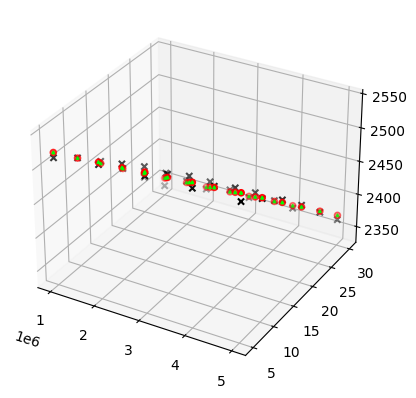

In [23]:
y_poly_lin = reg.predict(Xgrid)
ax.scatter(Xgrid[:, 0], Xgrid[:, 1], y_poly_lin, marker='^', color='#00ff00', s=3)
fig